In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

import pims
import trackpy as tp

from utils.utils import extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
from utils.utils import argnotnan, set_spines_visible, generate_video_with_text, create_scalarmappable


plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# 1. Paths and Read-In

In [4]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0331_090303_001.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps = vid_props[0]

frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"

# D-mid?
pixel_per_real_width = .75
mpp = 1.333  # microns_per_pixel
print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))  # before only used the green channel! now things look different in the locate function

img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

# Save figures
results_path = "./data/results/vortex/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)
fig_params = {"dpi" : 600, "bbox_inches" : "tight", "edgecolor" : None}

# bis 23sec, dann wieder ab sec30 bis ende: 30*60 >1420-1820
time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
num_frames = len(time) # time_idx

print("selected time num_frames=", num_frames)#

vid properties:  (60, 2760, 1920, 1080)
D MID - FHD, pixel_per_real_width =  0.75
real width (µm):  1440.36 
real height (µm): 810.2
selected time num_frames= 2359


In [5]:

process_frames = np.arange(0, num_frames, 2)

CALC_ZPROJ = False
if CALC_ZPROJ:
    subtract_frame = np.median(np.stack(frames[::2]), axis=0)
    plt.imshow(subtract_frame)
    
    zproj = []
    for nth in process_frames:
        zproj.append(frames[nth] - subtract_frame)
    zproj = np.stack(zproj)
    zproj = np.min(zproj, axis=0)

SAVE_NPY = False
if SAVE_NPY:
    np.save(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")

-164.90615 -0.28839999999999577 [-116.4538     -75.9368825   -5.4971   ]


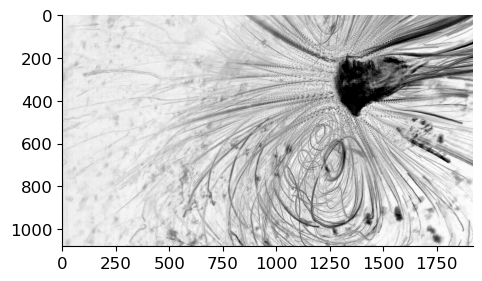

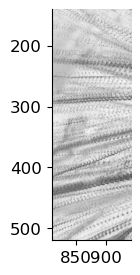

In [6]:
SAVE_FIGURES = False
vmin_ = np.percentile(zproj, 1)#-70 #np.min(zproj)
vmax_ = 0
print(np.min(zproj), np.max(zproj), np.percentile(zproj, [1,5,95]))

# R and D bbox
#rotifer_bbox = [835-xmin, 910-xmin, 50-ymin, 510-ymin]

detritus_bbox = [625, 770, 760, 1050]
point_count_bbox = [100, img_width-100, 520, 570]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cax = ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
#plot_bbox(detritus_bbox, "blue", ax=ax)
#plot_bbox(rotifer_bbox, "blue", ax=ax)
#plot_bbox(point_count_bbox, "m", ax=ax)
#ax.set(**ax_params); ax.invert_yaxis();
#cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[vmax_, vmin_], yticklabels=["max", "min"])
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-scale_num_process_frames{process_frames[-1]}.jpg", **fig_params) if SAVE_FIGURES else None


# fig, ax = plt.subplots(1, 1, figsize=(2, 2))
# ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
# plot_bbox(rotifer_bbox, "blue", ax=ax)
# plot_bbox(point_count_bbox, "m", ax=ax)
# ax.set(**ax_params); ax.invert_yaxis();
# ax.set(xlim=(550,1200), ylim=(150, 750), xticks=[], yticks=[]);
# fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-zoomin.jpg", **fig_params) if SAVE_FIGURES else None

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
ax.set(xlim=(810,940), ylim=(140, 520)); ax.invert_yaxis();
#

## Locate features for single frame

n features -  128


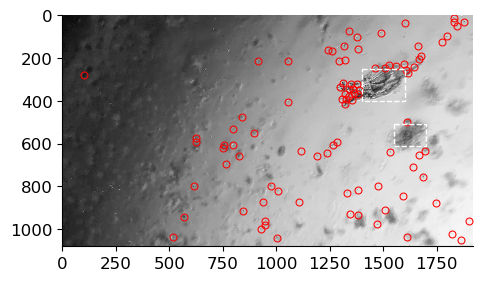

In [7]:
locate_params = {
    "diameter" : 15,
    "threshold" : 8,
    "invert" : True,
}
frame_nr = 0
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
rotifer_bbox = [1400, 1600, 250, 400]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]
# Detritus exclude
detritus_bbox = [1550, 1700, 510, 610]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});
#ax.set(xlim=(1250, 1750), ylim=(200, 450))
plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)


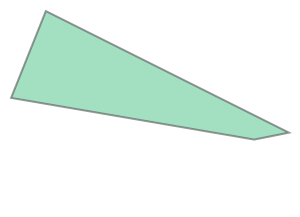

In [8]:
from shapely.geometry import Point, Polygon

def is_point_in_polygon(x, y, polygon):
    point = Point(x, y)
    return polygon.contains(point)

mask_polygon = Polygon([(1250, 300), (1300, 425), (1650, 250), (1600, 240)])
#plt.plot([x,y in mask_polygon])
mask_polygon

# 2. Batch Process frames

In [9]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)
fbatch_ori = fbatch.copy()

mask_polygon = Polygon([(1250, 300), (1300, 425), (1650, 250), (1600, 240)])
fbatch['inside_mask'] = fbatch.apply(lambda row: is_point_in_polygon(row['x'], row['y'], mask_polygon), axis=1)
fbatch = fbatch[~fbatch['inside_mask']]
fbatch = fbatch.drop(columns=['inside_mask'])

# lower_condition = (fbatch.y < 100) & (fbatch.x > 570)
# fbatch = fbatch[~lower_condition]
#rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
#fbatch = fbatch[~rotifer_condition]
detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]
#print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))
fbatch

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,11.040619,1828.930368,210.985508,1.371864,0.402925,26.118129,-25192.2287,-0.371924,0
1,29.081250,1833.358750,326.476608,1.691892,0.232828,27.750512,-25169.3447,-0.373339,0
2,30.259745,1878.756960,1245.916356,2.577143,0.280833,54.276736,-23776.5240,-0.485845,0
3,35.847291,1600.044335,248.530318,1.813107,0.222163,17.140022,-23611.1767,-0.503871,0
4,48.730042,1843.676822,1058.192306,2.957078,0.216913,30.199086,-23739.3282,-0.489787,0
...,...,...,...,...,...,...,...,...,...
398266,1046.932375,1120.974641,484.483974,2.218801,0.239587,27.439075,-26813.2035,-0.295150,2358
398267,1046.969091,938.500606,675.738425,2.702076,0.231464,30.305844,-22465.0657,-0.652788,2358
398268,1046.941667,1016.401587,1032.036867,4.151640,0.724943,37.677536,-24441.7881,-0.420919,2358
398269,1052.014981,1441.943820,109.346763,1.096470,0.157825,17.200614,-29662.0049,-0.217190,2358


# 3. Link particles / frames to trajectories

In [10]:
link_params = {
    "search_range" : 40,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/8); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 10981
7
N Before: 10981 
 N after filtering: 4275


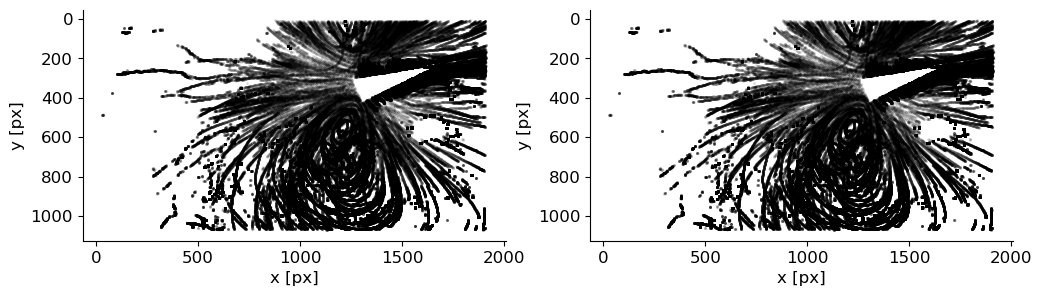

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
tp.scatter(trajs, ax=ax[0], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
tp.scatter(trajs, ax=ax[1], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
#ax[1].set(xlim=(1150, 1450), ylim=(200, 450))

number of particles = number of trajectories: 4275
number of particles (original): 4275 
number of particles remaining: 1506
number of particles = number of trajectories: 1506


[(1150.0, 1450.0), (200.0, 450.0)]

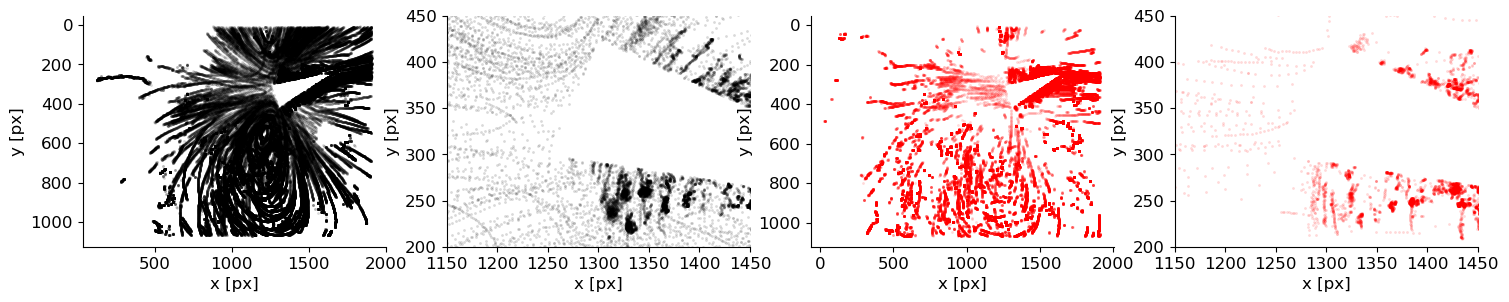

In [12]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std <= 5) | (stats.y_std <= 5)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

fig, ax = plt.subplots(1,4,figsize=(18,3))
tp.scatter(ctraj, ax=ax[0], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
ax[1].set(xlim=(1150, 1450), ylim=(200, 450))

tp.scatter(traj_rejected, ax=ax[2], plot_style={"ms" : 1, "alpha" : .15, "color" : "r", "mfc" : "none"});
tp.scatter(traj_rejected, ax=ax[3], plot_style={"ms" : 1, "alpha" : .15, "color" : "r", "mfc" : "none"});
ax[3].set(xlim=(1150, 1450), ylim=(200, 450))

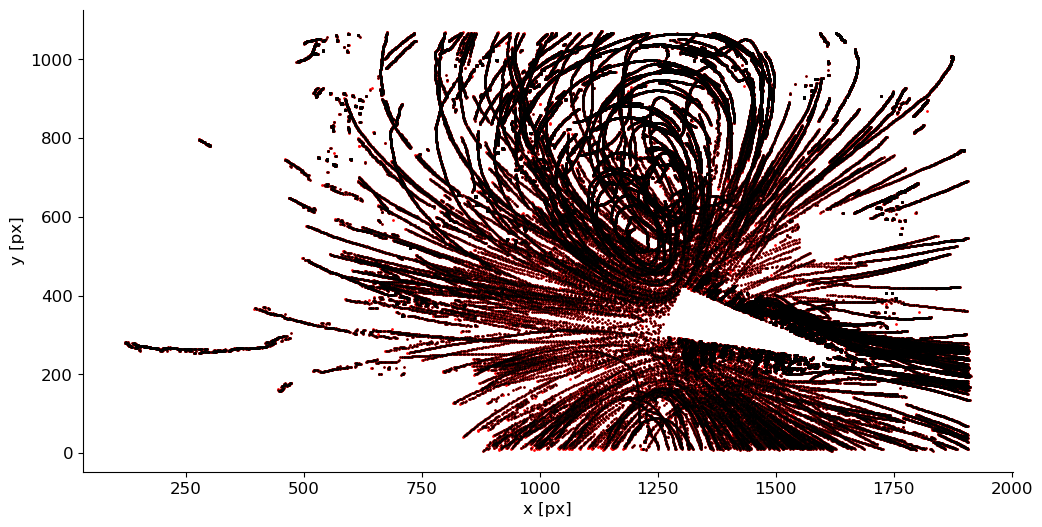

In [13]:
# check for velocit jumps!
df = ctraj[["x", "y", "particle", "frame"]].copy()
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)# * fps / mpp
df["v"] = df["v"].mask(df["v"]>=34)
df = df.dropna(subset="v")

fig, ax = plt.subplots(figsize=(6*2,3*2))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 1, "alpha" : 1, "color" : "r"});
tp.scatter(df, ax=ax, plot_style={"ms" : .5, "alpha" : 1, "color" : "k"}); ax.invert_yaxis();

(-15.0, 20.0)

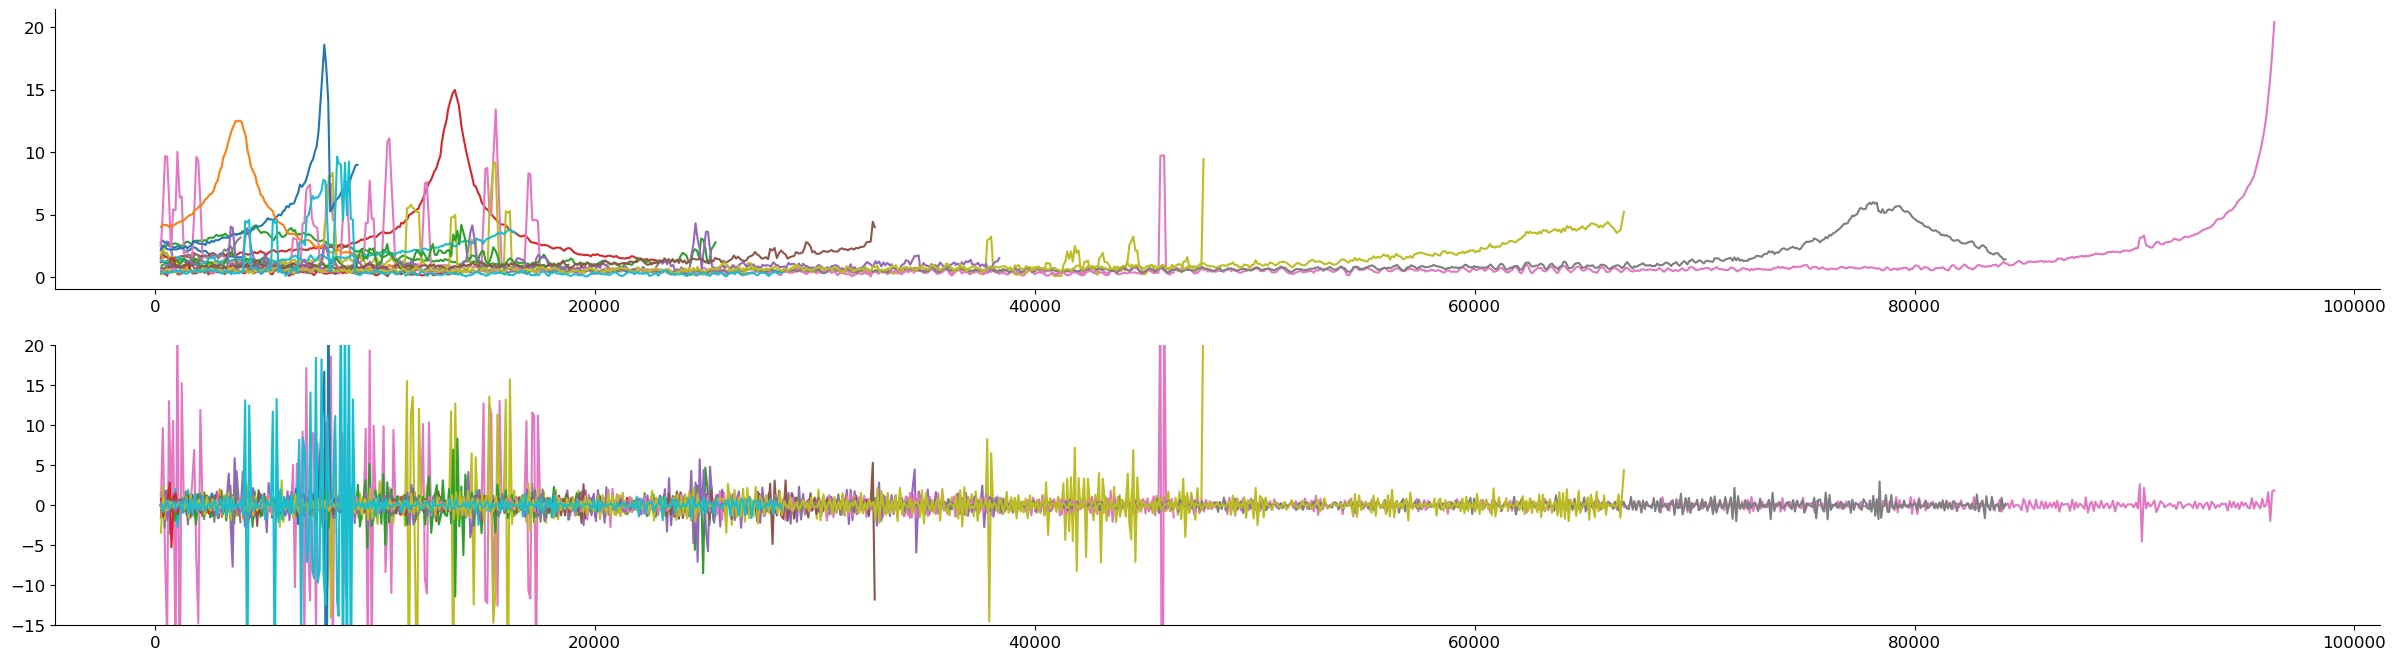

In [14]:
fig,ax = plt.subplots(2,1,figsize=(30,8))
particles = df.particle.unique()

for prt in particles[:20]:
    ax[0].plot(df.groupby("particle").get_group(prt)["v"].rolling(window=3).mean())
    ax[1].plot(df.groupby("particle").get_group(prt)["v"].diff().diff())

ax[1].set_ylim(-15,20)

In [15]:
keep_parts = []
for prt in particles:
    acc = df.groupby("particle").get_group(prt)["v"].diff().diff()
    #if not np.any((acc <= -7.5) | (acc > 7.5)):
    if not np.any((acc <= -10) | (acc > 11.5)):
        keep_parts.append(prt)

print(len(keep_parts))

keeptrajs = ctraj[ctraj.particle.isin(keep_parts)]
keeptrajs_ = df[df.particle.isin(keep_parts)]

points = keeptrajs_[["x", "y"]].where(keeptrajs_["v"].notna()).to_numpy()
v_xy = keeptrajs_["v"].where(keeptrajs_["v"].notna()).to_numpy()
dxy = keeptrajs_[["dx", "dy"]].where(keeptrajs_["v"].notna()).to_numpy()
print(v_xy.shape, points.shape, sum(np.isnan(dxy)), sum(np.isnan(points)))

578
(65277,) (65277, 2) [0 0] [0 0]


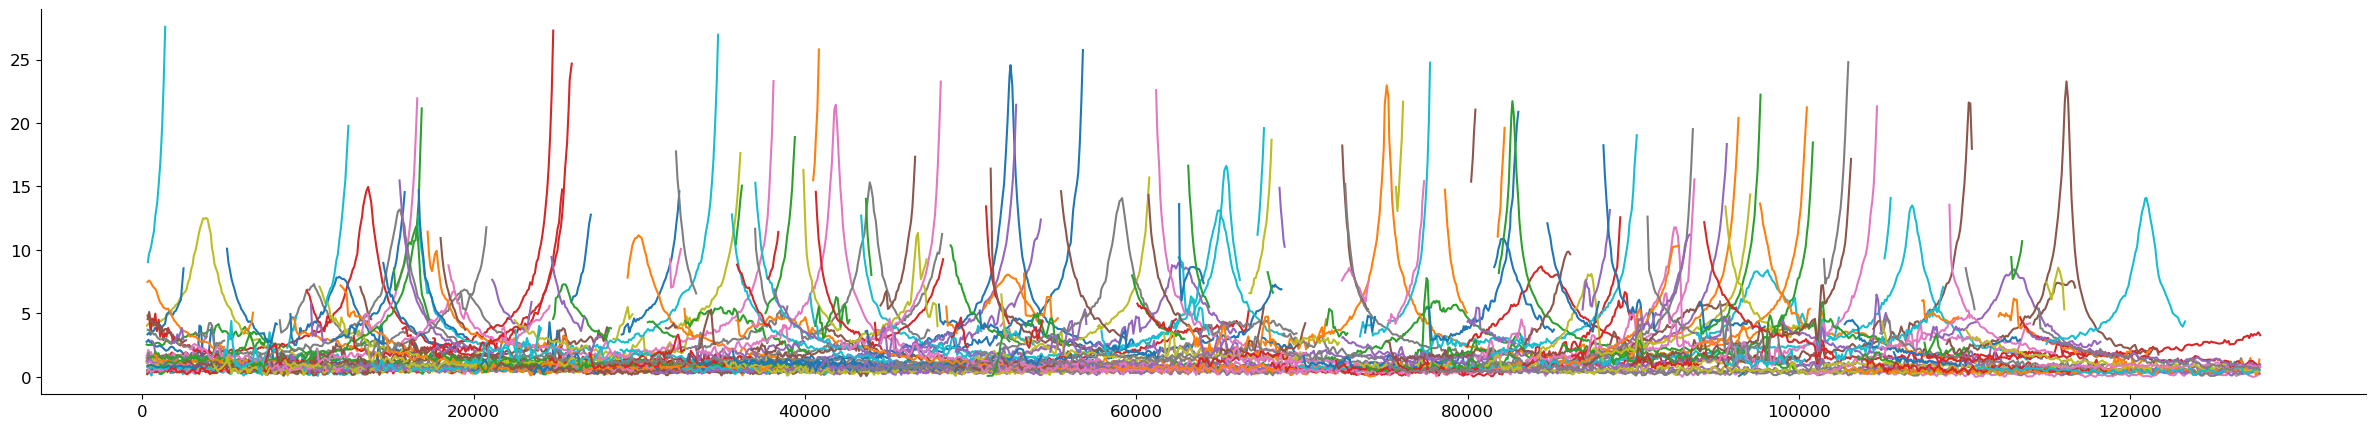

In [16]:
fig,ax = plt.subplots(figsize=(30,5))
for prt in keep_parts[:350]:
    plt.plot(keeptrajs_.groupby("particle").get_group(prt)["v"].rolling(window=3).mean())

30.00750187546887
percentiles vmap: 5.692946978586506 
omap 210.05128801491819


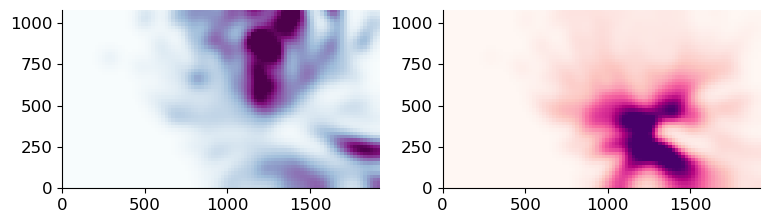

In [17]:
SAVE_FIGURES = True
bin_size_2d = 40
sigma_2d = 2
print(bin_size_2d / mpp)
cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 

occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=25)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 97.5)
ovmax = np.percentile(interpolated_omap, 97.5)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
#plot_bbox(rotifer_bbox, "k", ax=ax[0]); plot_bbox(detritus_bbox, "k", ax=ax[0])
#ax[0].set(**ax_params); ax[0].invert_yaxis();
#cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
#plot_bbox(rotifer_bbox, "k", ax=ax[1]); plot_bbox(detritus_bbox, "k", ax=ax[1])
#ax[1].set(**ax_params); ax[1].invert_yaxis();
#cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
print("percentiles vmap:", vvmax, "\nomap", ovmax)

In [19]:
point_count_bbox = [1000, 1500, 350, img_height]#[1150, 1230, 0, 765]
bbox_condition = (keeptrajs_.y >= point_count_bbox[2]) & (keeptrajs_.y < point_count_bbox[3]) & (keeptrajs_.x >= point_count_bbox[0]) & (keeptrajs_.x < point_count_bbox[1])

df_filt = pd.DataFrame()

for nth in keep_parts:
    traj = keeptrajs_.loc[keeptrajs_["particle"] == nth]
    traj = traj.loc[bbox_condition]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df_filt = pd.concat([df_filt, df_loop[1:]])

# XY Velocity at XY coordinates
velocities = df_filt[["dx", "dy"]].to_numpy()

# Velocity per point
df_filt["v_xy"] = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp
df_filt[['xnorm', 'ynorm']] = df_filt[['x', 'y']] * fps / mpp
df_filt.to_csv(f"{save_figure_path}/{vid_filename.split('.')[0]}_d_filt.csv", index=False)

vortex_trajs = df_filt.copy()
rotifer_cm_y = 350
vortex_trajs["yrot_norm"] = vortex_trajs["ynorm"] - rotifer_cm_y / mpp
vortex_trajs.to_csv(f"{save_figure_path}/{vid_filename.split('.')[0]}_vertical_vortex_trajs.csv", index=False)

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_39406/3980918165.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filt.groupby('y_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


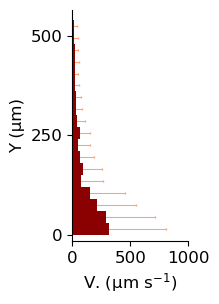

In [63]:
SAVE_FIGURES = False
bin_width = 40
rotifer_cm_y = 350
bin_edges = np.arange(point_count_bbox[2], point_count_bbox[3], bin_width)
df_filt["y_bin"] = pd.cut(df_filt["y"], bins=bin_edges)
grouped = df_filt.groupby('y_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - rotifer_cm_y) / mpp
#bin_centers = (bin_centers) / mpp


fig, ax = plt.subplots(figsize=(1.5,3))
plt.errorbar(medians, bin_centers, xerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=1, capsize=1, zorder=1)
plt.barh(bin_centers, medians, height=bin_width/mpp, color="darkred", zorder=2)
#plot_bbox([0, 200, 1670, 1710], c="b", ax=ax)
ax.set(xlim=(0,1000),ylim=(-15, max(bin_centers)+bin_width), yticks=[0,250, 500], ylabel="Y (µm)", xlabel="V. (µm s$^{-1}$)")#yticklabels=[0, .5, 1]
#ax.invert_yaxis()
ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-median-velocities-histogram_.jpg", **fig_params) #if SAVE_FIGURES else None

In [52]:
from scipy.interpolate import griddata
grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 25), np.arange(0, img_height, 25))

# Interpolate velocities onto grid
#grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
#grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')
grid_u = griddata(points, dxy[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, dxy[:, 1], (grid_x, grid_y), method='linear')

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)

print(np.nanmin(omega), np.nanmax(omega))

-0.5535034408401178 0.3569279082058219


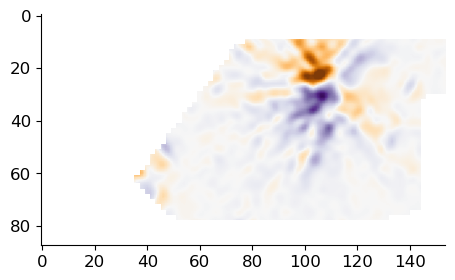

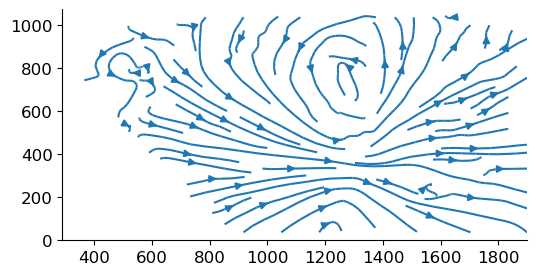

In [57]:

vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=1)

plt.figure()
plt.imshow(vort_map, vmin=-.25,vmax=.25, cmap="PuOr", alpha=1)

plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v)
#plt.gca().invert_yaxis()

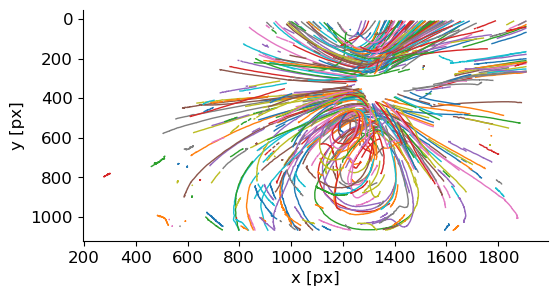

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [62]:
plt.figure()
tp.plot_traj(keeptrajs_)

## Visualize Trajectories

In [ ]:
# fig, ax = plt.subplots()
# tp.plot_traj(ctraj, superimpose=frames[frame_nr], ax=ax, plot_style={"color": "k", "lw" : 1, "alpha" : .5});
# tp.annotate(ctraj[ctraj.frame == frame_nr], frames[frame_nr], ax=ax, plot_style={"markersize" : 7, "markeredgewidth" : 1}); 

In [ ]:
# displacement_array = reindex_calculate_displacement_and_stack(ctraj, np.arange(0, time_idx))
# displacement_array = (displacement_array)
# df_disp = pd.DataFrame(displacement_array.T)
# df_disp = df_disp.replace(0.0, np.nan)

# plt.subplots()
# plt.imshow(df_disp.values.T, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=np.nanmax(df_disp.values))#, extent=[0, fr_time[-1], displacement_array.shape[0], 0]

# plt.subplots()
# plt.plot(df_disp.values); # displacement_array.T

In [ ]:
corona_center = (1300, 350)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
ctraj['velocity'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj['rdist'] = np.sqrt((ctraj['x'] - corona_center[0]) **2 + (ctraj['y'] - corona_center[1]) **2)
bins = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), 30)
ctraj['rbin'] = pd.cut(ctraj['rdist'], bins)
ctraj_ = ctraj.dropna()
bin_stats = ctraj_.groupby('rbin', observed=True)['velocity'].agg(['mean', 'std', 'count'])
bin_centers = [round(interval.mid, 1) for interval in bin_stats.index.categories]

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')

In [ ]:
ctraj_['angle'] = np.arctan2(ctraj_['y'] - corona_center[1], ctraj_['x'] - corona_center[0])

num_radial_bins = 30
num_angle_bins = 30
radial_bins = np.linspace(ctraj_['rdist'].min(), ctraj_['rdist'].max(), num_radial_bins + 1)
angle_bins = np.linspace(-np.pi, np.pi, num_angle_bins + 1)

ctraj_['rbin'] = pd.cut(ctraj_['rdist'], bins=radial_bins, include_lowest=True)
ctraj_['angle_bin'] = pd.cut(ctraj_['angle'], bins=angle_bins, include_lowest=True)

# Drop rows with NaN values from the diff operation
ctraj = ctraj_.dropna()

# Group by rbin and angle_bin, then calculate counts and mean velocity
bin_stats = ctraj.groupby(['rbin', 'angle_bin']).agg(
    count=('velocity', 'size'),
    mean_velocity=('velocity', 'mean'),
    std_velocity=('velocity', 'std')
).reset_index()

# Prepare data for plotting counts
counts = bin_stats.pivot(index='rbin', columns='angle_bin', values='count').fillna(0)
mean_velocities = bin_stats.pivot(index='rbin', columns='angle_bin', values='mean_velocity').fillna(0)
std_velocities = bin_stats.pivot(index='rbin', columns='angle_bin', values='std_velocity').fillna(0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(9, 3), subplot_kw=dict(projection='polar'))

# Plot counts
theta_counts = np.linspace(-np.pi, np.pi, len(counts.columns) + 1)
r_counts = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), len(counts.index) + 1)
theta_grid, r_grid = np.meshgrid(theta_counts, r_counts)
vmin_counts = counts.values.min()
vmax_counts = counts.values.max()
theta_grid = theta_grid[:-1, :-1]
r_grid = r_grid[:-1, :-1]

c = ax[0].pcolormesh(theta_grid, r_grid, counts.values, shading='auto', vmin=vmin_counts, vmax=700, cmap="cividis")
ax[0].set_title('Counts per Bin')
fig.colorbar(c, ax=ax[0])

# Plot average velocities
theta_vel = np.linspace(-np.pi, np.pi, len(mean_velocities.columns) + 1)
r_vel = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), len(mean_velocities.index) + 1)
theta_grid, r_grid = np.meshgrid(theta_vel, r_vel)
vmin_velocity = mean_velocities.values.min()
vmax_velocity = mean_velocities.values.max()
theta_grid = theta_grid[:-1, :-1]
r_grid = r_grid[:-1, :-1]
print(vmin_velocity, vmax_velocity)

c = ax[1].pcolormesh(theta_grid, r_grid, mean_velocities.values, shading='auto', vmin=vmin_velocity, vmax=10, cmap="cividis")
ax[1].set_title('Average Velocity per Bin')
fig.colorbar(c, ax=ax[1])

In [ ]:
theta_grid.shape, r_grid.shape, counts.values.shape